In [2]:
from pymodules import sim_functions as sf
from pymodules.sim_functions import b2
import time
import json
from pymodules.ML_params import *

In [3]:
cell = "NMO_00892"; 

In [4]:
morph_d8 = b2.spatialneuron.morphology.Morphology.from_swc_file(f"morphs/{cell}_depth8.swc", spherical_soma=True)
morph_d13 = b2.spatialneuron.morphology.Morphology.from_swc_file(f"morphs/{cell}_depth13.swc", spherical_soma=True)
morph_d14 = b2.spatialneuron.morphology.Morphology.from_swc_file(f"morphs/{cell}_depth14.swc", spherical_soma=True)
morph_full = b2.spatialneuron.morphology.Morphology.from_swc_file(f"morphs/{cell}_full.swc", spherical_soma=True) 

In [11]:
with open(f"data/{cell}_morph_onset.json") as f:
    onset_dict = json.load(f)
    print(onset_dict)
    Iin = onset_dict["Ion"]*b2.amp

{'Ion': [1.7031250000000003e-10, 3.3619689941406256e-10, 3.8028564453125006e-10, 4.810363769531249e-10], 'ron': [1.0000100000999999, 1.0000100001000014, 1.7000170001700023, 5.850058500585008]}


In [13]:
α = 4.5 # scaling factor for the soma
β = 1.0 # scaling factor for the dendrites
morphs = [morph_d8, morph_d13, morph_d14, morph_full]
# Iin = [170.31250000000003*b2.pA, 0.33619689941406256*b2.nA, 0.3802856445312499*b2.nA, 0.48104095458984386*b2.nA] # input currents to use for the different morphology stages

In [14]:
def prc_calc(k, len_σ, Δv, θin):
    neuron = b2.SpatialNeuron(morphology=morphs[k], model=eqs, Cm=α*Cm, Ri=250*b2.ohm*b2.cm, method='exponential_euler')
    neuron[0:len_σ].gL = α*gL0
    neuron.EL = EL0
    neuron[0:len_σ].gf = α*gf0
    neuron[0:len_σ].gs = α*gs0; # make only the soma active
    if len(neuron) > len_σ:
        neuron.Cm[len_σ::] = 0.25*β*Cm
        neuron[len_σ::].gL = β*gL0
    
    dt = 0.1*b2.ms
    
    neuron.I[0] = Iin[k]
    mon = b2.StateMonitor(neuron, ('v','n'), record=range(0,len(neuron)))
    t = mon.t
    tmax = 6000*b2.ms
    b2.run(tmax, report='text')
    mlc = 3
    vth = -8.0
    vstart, nstart, Np = sf.LC_setup(mon.v/b2.mV, mon.n[0], vth, mlc)
    print(Np)
    
    in_idx = [int(b2.floor(x*Np)) for x in θin]
    P = 5
    
    Tp = Np*dt

    tic = time.perf_counter()
    Δθ = sf.PRC_extract(neuron, Iin[k], in_idx, Δv, P, Np, dt, vstart, nstart, vth)
    toc = time.perf_counter()
    print(toc-tic)
    
    return Δθ

In [22]:
Δv = b2.array([0.05, 0.025, 3e-4, 1.0e-1])*b2.mV

In [16]:
θin = b2.linspace(0.025, 0.975, 40)
Δθ = b2.zeros((len(morphs),len(θin)))

In [25]:
for k in range(len(morphs)):
    Δθ[k,:] = prc_calc(k, 36, Δv[k], θin)

Starting simulation at t=0. s for a duration of 6. s
6. s (100%) simulated in 2s
10184.0
71.4031192140028
Starting simulation at t=0. s for a duration of 6. s
6. s (100%) simulated in 5s
9719.0
157.83698508100133
Starting simulation at t=0. s for a duration of 6. s
6. s (100%) simulated in 6s
5934.333333333333
113.35780778099797
Starting simulation at t=0. s for a duration of 6. s
6. s (100%) simulated in 9s
1707.3333333333333
45.815061173001595


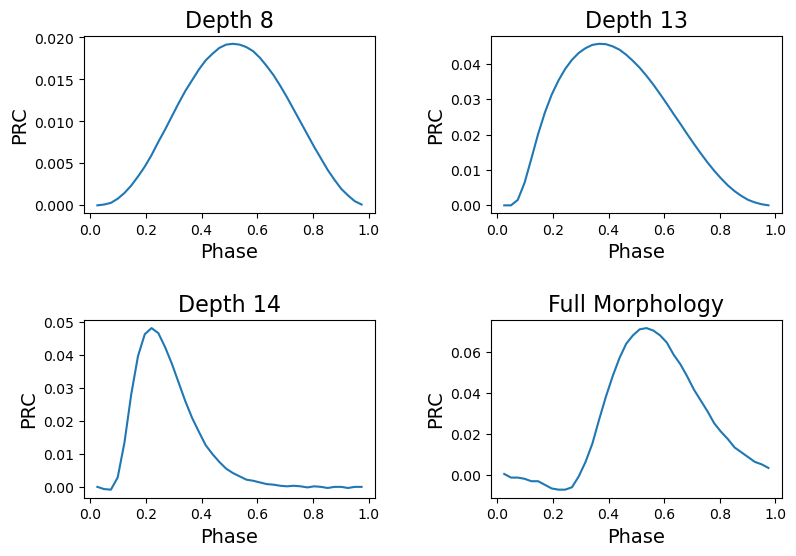

In [26]:
 fig = b2.figure(figsize=(9, 6))

fig.subplots_adjust(wspace=0.4, hspace=0.6)

fig.add_subplot(221)
b2.plot(θin, Δθ[0,:], "-")
b2.title("Depth 8", fontsize=16)
b2.xlabel("Phase", fontsize=14)
b2.ylabel("PRC", fontsize=14)

fig.add_subplot(222)
b2.plot(θin, Δθ[1,:], "-")
b2.title("Depth 13", fontsize=16)
b2.xlabel("Phase", fontsize=14)
b2.ylabel("PRC", fontsize=14)

fig.add_subplot(223)
b2.plot(θin, Δθ[2,:], "-")
b2.title("Depth 14", fontsize=16)
b2.xlabel("Phase", fontsize=14)
b2.ylabel("PRC", fontsize=14)

fig.add_subplot(224)
b2.plot(θin, Δθ[3,:], "-")
b2.title("Full Morphology", fontsize=16)
b2.xlabel("Phase", fontsize=14)
b2.ylabel("PRC", fontsize=14);

In [27]:
jdict = {"delta_v": (Δv/b2.mV).tolist(), "Iin" : (Iin/b2.amp).tolist(), "theta_in" : θin.tolist(), "PRC" : Δθ.tolist()}

In [28]:
with open(f"data/PRC_{cell}_depths.json", "w") as json_file:
    json.dump(jdict, json_file)